In [95]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
import cv2
import os
import random
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torch import nn
import torch.nn.functional as F
from torch.optim import Optimizer
from torch.optim.lr_scheduler import StepLR
import copy
from tqdm import tqdm

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo,encoding='latin1')
    return dict

# Open the meta file
meta = unpickle('cifar-10-batches-py/batches.meta')
# Open the data file
d1 = unpickle('cifar-10-batches-py/data_batch_1')
d2 = unpickle('cifar-10-batches-py/data_batch_2')
d3 = unpickle('cifar-10-batches-py/data_batch_3')
d4 = unpickle('cifar-10-batches-py/data_batch_4')
d5 = unpickle('cifar-10-batches-py/data_batch_5')
# Open the test file
test = unpickle('cifar-10-batches-py/test_batch')




cuda:0


In [96]:
# # Print the keys of the data
# print(type(meta))
# print(meta.keys()) 
# print("Label Names:", meta['label_names'] )

# # Print d1 keys
# print(d1.keys()) 
# print(d1['labels'][0:10])
# print(d1['data'].shape)

# # Print d1[1]
# print(d1['data'][1])



In [97]:
# Reshape the data to 32x32x3
d1_img = d1['data'].reshape((10000, 3, 32, 32)).transpose(0,2,3,1).astype("uint8")
d2_img = d2['data'].reshape((10000, 3, 32, 32)).transpose(0,2,3,1).astype("uint8")
d3_img = d3['data'].reshape((10000, 3, 32, 32)).transpose(0,2,3,1).astype("uint8")
d4_img = d4['data'].reshape((10000, 3, 32, 32)).transpose(0,2,3,1).astype("uint8")
d5_img = d5['data'].reshape((10000, 3, 32, 32)).transpose(0,2,3,1).astype("uint8")
test_img = test['data'].reshape((10000, 3, 32, 32)).transpose(0,2,3,1).astype("uint8")
# Add labels to the images using meta data
d1_labels = np.array(d1['labels'])
d2_labels = np.array(d2['labels'])
d3_labels = np.array(d3['labels'])
d4_labels = np.array(d4['labels'])
d5_labels = np.array(d5['labels'])
test_labels = np.array(test['labels'])

# Change the labels to meta labels
d1_labels = np.array([meta['label_names'][i] for i in d1_labels])
d2_labels = np.array([meta['label_names'][i] for i in d2_labels])
d3_labels = np.array([meta['label_names'][i] for i in d3_labels])
d4_labels = np.array([meta['label_names'][i] for i in d4_labels])
d5_labels = np.array([meta['label_names'][i] for i in d5_labels])
test_labels = np.array([meta['label_names'][i] for i in test_labels])

In [98]:
# Concatenate the data
data = np.concatenate((d1_img,d2_img,d3_img,d4_img,d5_img),axis=0)
labels = np.concatenate((d1_labels,d2_labels,d3_labels,d4_labels,d5_labels),axis=0)

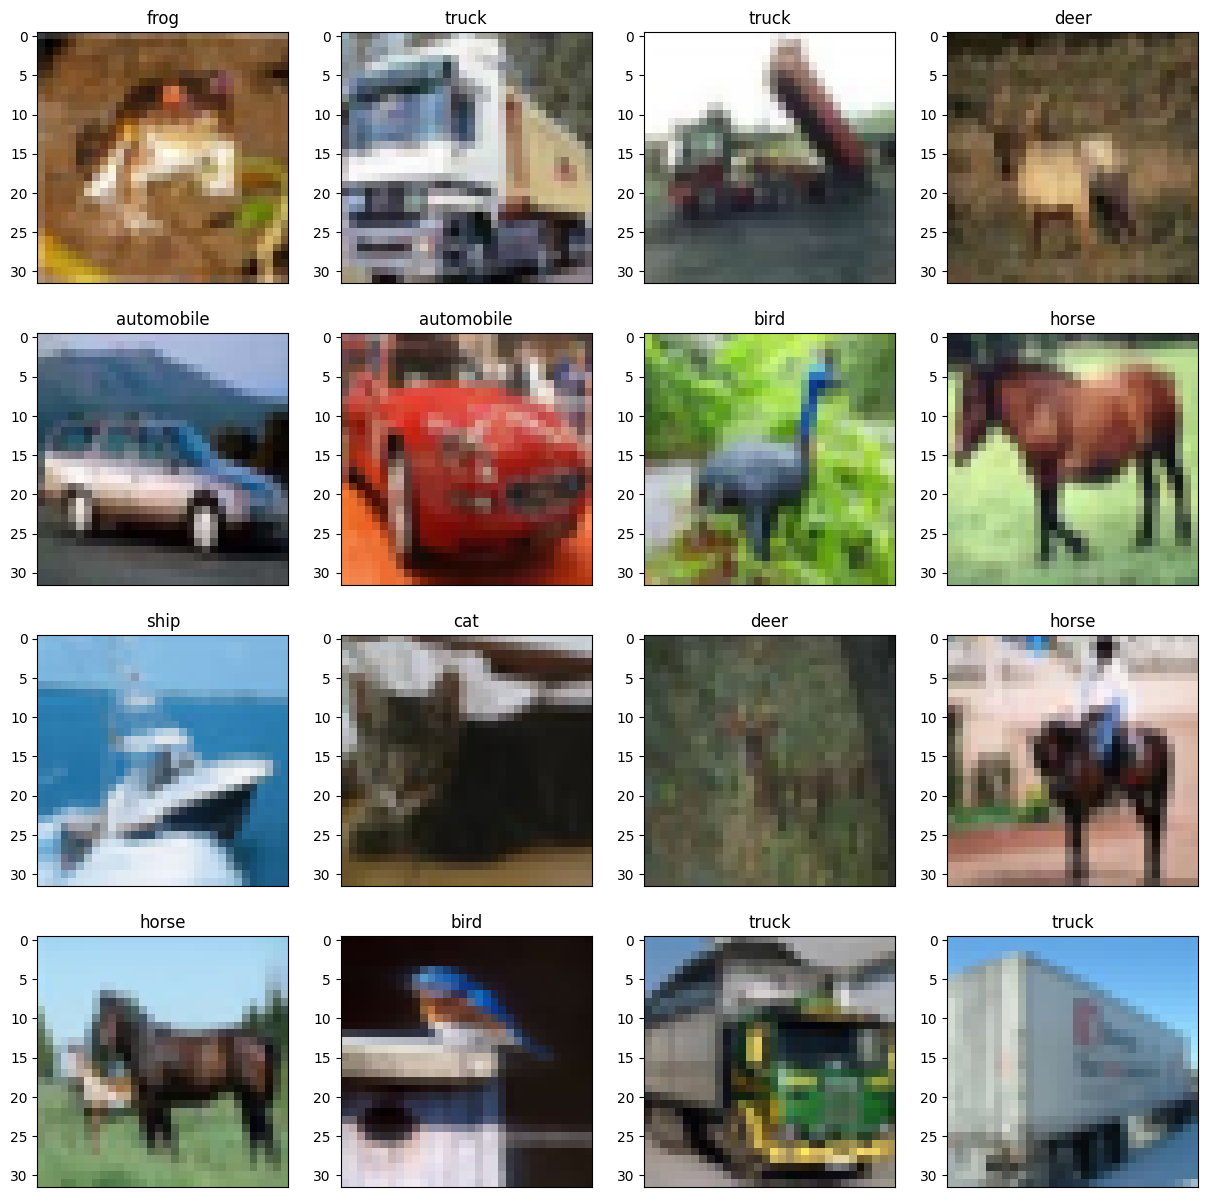

In [99]:
# Preview the images first
plt.figure(figsize=(15,15))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(data[i])
    plt.title(labels[i])
    plt.xticks([])
plt.show()


In [100]:

#load the data into torchvision.datasets
trainset = datasets.CIFAR10(root='./', train=True, download=False, transform=transforms.ToTensor())
batch_size = 32
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

testset = datasets.CIFAR10(root='./', train=False, download=False, transform=transforms.ToTensor())
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

In [101]:
class LeNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 5, 1, padding=2)
        self.bn1 = nn.BatchNorm2d(32)  # Batch normalization after the first convolutional layer
        self.conv2 = nn.Conv2d(32, 64, 3, 1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 64, 3, 1, padding=1)
        self.bn3 = nn.BatchNorm2d(64)  # Batch normalization after the third convolutional layer
        self.conv4 = nn.Conv2d(64, 128, 3, 1, padding=1)
        self.bn4 = nn.BatchNorm2d(128)  # Batch normalization after the third convolutional layer
        self.conv5 = nn.Conv2d(128, 128, 3, 1, padding=1)
        self.bn5 = nn.BatchNorm2d(128)
        self.fc1 = nn.Linear(4 * 4 * 128, 512)
        self.fc2 = nn.Linear(512,256)
        self.dropout = nn.Dropout(0.5)
        self.fc3 = nn.Linear(256, 10)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, 2, 2)
        x = self.dropout(x)
        
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.max_pool2d(x, 2, 2)
        x = self.dropout(x) 
        
        x = F.relu(self.bn5(self.conv5(x)))
        x = F.max_pool2d(x, 2, 2)
        x = self.dropout(x)
        
        x = x.view(-1, 4 * 4 * 128)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        
        return x


In [102]:
model = LeNet().to(device)
print(model)

LeNet(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=2048, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (dropout): Dropout(p=0.5, inplac

In [103]:
# Define the loss function and optimizer
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


In [104]:
# Train the model
num_epochs = 100   # Adjust the number of epochs as needed
train_loss_list = []
val_loss_list = []
train_acc_list = []
val_acc_list = []

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    total_correct_train = 0
    total_samples_train = 0
    epoch_loss_train = 0
    
    # Training loop
    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs} (Training)", leave=False):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        total_correct_train += (outputs.argmax(1) == labels).sum().item()
        total_samples_train += labels.size(0)
        epoch_loss_train += loss.item()

        loss.backward()
        optimizer.step()

    average_epoch_loss_train = epoch_loss_train / len(train_loader)
    train_loss_list.append(average_epoch_loss_train)
    train_acc = total_correct_train / total_samples_train * 100
    train_acc_list.append(train_acc)

    # Validation loop
    model.eval()  # Set the model to evaluation mode
    total_correct_val = 0
    total_samples_val = 0
    epoch_loss_val = 0

    with torch.no_grad():
        for val_inputs, val_labels in tqdm(test_loader, desc=f"Epoch {epoch + 1}/{num_epochs} (Validation)", leave=False):
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)

            val_outputs = model(val_inputs)
            val_loss = criterion(val_outputs, val_labels)

            total_correct_val += (val_outputs.argmax(1) == val_labels).sum().item()
            total_samples_val += val_labels.size(0)
            epoch_loss_val += val_loss.item()

    average_epoch_loss_val = epoch_loss_val / len(test_loader)
    val_loss_list.append(average_epoch_loss_val)
    val_acc = total_correct_val / total_samples_val * 100
    val_acc_list.append(val_acc)

    print(f"Epoch [{str(epoch + 1).zfill(2)}/{str(num_epochs).zfill(2)}], Train Loss: {average_epoch_loss_train:.4f}, Train Acc: {train_acc:.2f}%, Val Loss: {average_epoch_loss_val:.4f}, Val Acc: {val_acc:.2f}%")


# Save the trained model if needed
torch.save(model.state_dict(), 'lenet_model.pth')

Epoch [01/100], Train Loss: 1.7250, Train Acc: 34.98%, Val Loss: 1.5891, Val Acc: 43.64%


Epoch [02/100], Train Loss: 1.4089, Train Acc: 49.11%, Val Loss: 1.2438, Val Acc: 55.50%


Epoch [03/100], Train Loss: 1.2365, Train Acc: 56.21%, Val Loss: 0.9594, Val Acc: 66.92%


Epoch [04/100], Train Loss: 1.1211, Train Acc: 60.95%, Val Loss: 0.9448, Val Acc: 68.19%


Epoch [05/100], Train Loss: 1.0416, Train Acc: 63.98%, Val Loss: 1.0181, Val Acc: 64.19%


Epoch [06/100], Train Loss: 0.9843, Train Acc: 66.52%, Val Loss: 0.8138, Val Acc: 72.40%


Epoch [07/100], Train Loss: 0.9413, Train Acc: 68.15%, Val Loss: 0.7779, Val Acc: 73.16%


Epoch [08/100], Train Loss: 0.9042, Train Acc: 69.47%, Val Loss: 0.7389, Val Acc: 75.32%


Epoch [09/100], Train Loss: 0.8724, Train Acc: 70.57%, Val Loss: 0.7253, Val Acc: 74.97%


Epoch [10/100], Train Loss: 0.8454, Train Acc: 71.21%, Val Loss: 0.6797, Val Acc: 76.79%


Epoch [11/100], Train Loss: 0.8219, Train Acc: 72.42%, Val Loss: 0.6893, Val Acc: 76.33%


Epoch [12/100], Train Loss: 0.8038, Train Acc: 72.85%, Val Loss: 0.6677, Val Acc: 77.07%


Epoch [13/100], Train Loss: 0.7882, Train Acc: 73.61%, Val Loss: 0.6396, Val Acc: 78.72%


Epoch [14/100], Train Loss: 0.7633, Train Acc: 74.54%, Val Loss: 0.6842, Val Acc: 75.77%


Epoch [15/100], Train Loss: 0.7501, Train Acc: 74.81%, Val Loss: 0.6313, Val Acc: 79.06%


Epoch [16/100], Train Loss: 0.7376, Train Acc: 75.06%, Val Loss: 0.5877, Val Acc: 80.08%


Epoch [17/100], Train Loss: 0.7255, Train Acc: 75.53%, Val Loss: 0.5875, Val Acc: 80.62%


Epoch [18/100], Train Loss: 0.7134, Train Acc: 76.22%, Val Loss: 0.6009, Val Acc: 79.39%


Epoch [19/100], Train Loss: 0.7045, Train Acc: 76.35%, Val Loss: 0.5983, Val Acc: 79.66%


Epoch [20/100], Train Loss: 0.6919, Train Acc: 77.00%, Val Loss: 0.5796, Val Acc: 80.60%


Epoch [21/100], Train Loss: 0.6827, Train Acc: 77.08%, Val Loss: 0.5582, Val Acc: 81.62%


Epoch [22/100], Train Loss: 0.6721, Train Acc: 77.65%, Val Loss: 0.5775, Val Acc: 80.61%


Epoch [23/100], Train Loss: 0.6635, Train Acc: 77.88%, Val Loss: 0.5605, Val Acc: 81.21%


Epoch [24/100], Train Loss: 0.6578, Train Acc: 78.20%, Val Loss: 0.5632, Val Acc: 81.24%


Epoch [25/100], Train Loss: 0.6546, Train Acc: 78.38%, Val Loss: 0.5244, Val Acc: 82.19%


Epoch [26/100], Train Loss: 0.6399, Train Acc: 78.65%, Val Loss: 0.5348, Val Acc: 82.05%


Epoch [27/100], Train Loss: 0.6353, Train Acc: 78.92%, Val Loss: 0.5185, Val Acc: 82.10%


Epoch [28/100], Train Loss: 0.6303, Train Acc: 79.02%, Val Loss: 0.5246, Val Acc: 82.73%


Epoch [29/100], Train Loss: 0.6301, Train Acc: 79.00%, Val Loss: 0.5359, Val Acc: 81.40%


Epoch [30/100], Train Loss: 0.6232, Train Acc: 79.23%, Val Loss: 0.5279, Val Acc: 82.13%


Epoch [31/100], Train Loss: 0.6090, Train Acc: 79.72%, Val Loss: 0.5233, Val Acc: 82.04%


Epoch [32/100], Train Loss: 0.6083, Train Acc: 79.84%, Val Loss: 0.5032, Val Acc: 82.82%


Epoch [33/100], Train Loss: 0.6008, Train Acc: 80.19%, Val Loss: 0.4940, Val Acc: 83.73%


Epoch [34/100], Train Loss: 0.5967, Train Acc: 80.07%, Val Loss: 0.5030, Val Acc: 83.14%


Epoch [35/100], Train Loss: 0.5902, Train Acc: 80.40%, Val Loss: 0.4928, Val Acc: 83.67%


Epoch [36/100], Train Loss: 0.5887, Train Acc: 80.47%, Val Loss: 0.5209, Val Acc: 82.47%


Epoch [37/100], Train Loss: 0.5884, Train Acc: 80.35%, Val Loss: 0.4812, Val Acc: 83.89%


Epoch [38/100], Train Loss: 0.5813, Train Acc: 80.70%, Val Loss: 0.4980, Val Acc: 83.15%


Epoch [39/100], Train Loss: 0.5752, Train Acc: 80.95%, Val Loss: 0.4863, Val Acc: 83.84%


Epoch [40/100], Train Loss: 0.5756, Train Acc: 80.89%, Val Loss: 0.4882, Val Acc: 83.65%


Epoch [41/100], Train Loss: 0.5652, Train Acc: 81.31%, Val Loss: 0.5133, Val Acc: 82.48%


Epoch [42/100], Train Loss: 0.5627, Train Acc: 81.41%, Val Loss: 0.4849, Val Acc: 83.41%


Epoch [43/100], Train Loss: 0.5521, Train Acc: 81.77%, Val Loss: 0.4808, Val Acc: 83.69%


Epoch [44/100], Train Loss: 0.5616, Train Acc: 81.59%, Val Loss: 0.4858, Val Acc: 83.38%


Epoch [45/100], Train Loss: 0.5587, Train Acc: 81.35%, Val Loss: 0.4946, Val Acc: 82.49%


Epoch [46/100], Train Loss: 0.5525, Train Acc: 81.65%, Val Loss: 0.4838, Val Acc: 83.56%


Epoch [47/100], Train Loss: 0.5437, Train Acc: 82.03%, Val Loss: 0.4667, Val Acc: 84.37%


Epoch [48/100], Train Loss: 0.5381, Train Acc: 82.16%, Val Loss: 0.4741, Val Acc: 83.90%


Epoch [49/100], Train Loss: 0.5355, Train Acc: 82.24%, Val Loss: 0.4753, Val Acc: 83.58%


Epoch [50/100], Train Loss: 0.5355, Train Acc: 82.21%, Val Loss: 0.4663, Val Acc: 84.11%


Epoch [51/100], Train Loss: 0.5341, Train Acc: 82.48%, Val Loss: 0.4858, Val Acc: 83.42%


Epoch [52/100], Train Loss: 0.5308, Train Acc: 82.41%, Val Loss: 0.4607, Val Acc: 84.55%


Epoch [53/100], Train Loss: 0.5240, Train Acc: 82.72%, Val Loss: 0.4642, Val Acc: 84.23%


Epoch [54/100], Train Loss: 0.5271, Train Acc: 82.38%, Val Loss: 0.4506, Val Acc: 84.62%


Epoch [55/100], Train Loss: 0.5198, Train Acc: 82.83%, Val Loss: 0.4610, Val Acc: 84.60%


Epoch [56/100], Train Loss: 0.5105, Train Acc: 83.14%, Val Loss: 0.4558, Val Acc: 84.95%


Epoch [57/100], Train Loss: 0.5179, Train Acc: 82.87%, Val Loss: 0.4615, Val Acc: 84.00%


Epoch [58/100], Train Loss: 0.5074, Train Acc: 83.21%, Val Loss: 0.4613, Val Acc: 84.72%


Epoch [59/100], Train Loss: 0.5082, Train Acc: 83.24%, Val Loss: 0.4519, Val Acc: 84.32%


Epoch [60/100], Train Loss: 0.5049, Train Acc: 83.12%, Val Loss: 0.4491, Val Acc: 84.94%


Epoch [61/100], Train Loss: 0.5118, Train Acc: 83.07%, Val Loss: 0.4441, Val Acc: 85.05%


Epoch [62/100], Train Loss: 0.5077, Train Acc: 83.24%, Val Loss: 0.4653, Val Acc: 84.26%


Epoch [63/100], Train Loss: 0.5050, Train Acc: 83.37%, Val Loss: 0.4593, Val Acc: 84.69%


Epoch [64/100], Train Loss: 0.5019, Train Acc: 83.47%, Val Loss: 0.4465, Val Acc: 84.96%


Epoch [65/100], Train Loss: 0.5019, Train Acc: 83.34%, Val Loss: 0.4533, Val Acc: 84.05%


Epoch [66/100], Train Loss: 0.4945, Train Acc: 83.50%, Val Loss: 0.4646, Val Acc: 84.21%


Epoch [67/100], Train Loss: 0.4961, Train Acc: 83.65%, Val Loss: 0.4357, Val Acc: 85.31%


Epoch [68/100], Train Loss: 0.4846, Train Acc: 83.71%, Val Loss: 0.4521, Val Acc: 84.37%


Epoch [69/100], Train Loss: 0.4854, Train Acc: 83.97%, Val Loss: 0.4483, Val Acc: 84.55%


Epoch [70/100], Train Loss: 0.4870, Train Acc: 83.98%, Val Loss: 0.4476, Val Acc: 84.89%


Epoch [71/100], Train Loss: 0.4875, Train Acc: 83.98%, Val Loss: 0.4728, Val Acc: 83.80%


Epoch [72/100], Train Loss: 0.4816, Train Acc: 84.19%, Val Loss: 0.4590, Val Acc: 84.55%


Epoch [73/100], Train Loss: 0.4817, Train Acc: 84.11%, Val Loss: 0.4537, Val Acc: 84.43%


Epoch [74/100], Train Loss: 0.4863, Train Acc: 84.19%, Val Loss: 0.4327, Val Acc: 85.00%


Epoch [75/100], Train Loss: 0.4770, Train Acc: 84.32%, Val Loss: 0.4341, Val Acc: 85.22%


Epoch [76/100], Train Loss: 0.4759, Train Acc: 84.29%, Val Loss: 0.4442, Val Acc: 85.15%


Epoch [77/100], Train Loss: 0.4811, Train Acc: 84.14%, Val Loss: 0.4544, Val Acc: 84.83%


Epoch [78/100], Train Loss: 0.4683, Train Acc: 84.53%, Val Loss: 0.4494, Val Acc: 84.74%


Epoch [79/100], Train Loss: 0.4674, Train Acc: 84.47%, Val Loss: 0.4294, Val Acc: 85.52%


Epoch [80/100], Train Loss: 0.4742, Train Acc: 84.45%, Val Loss: 0.4208, Val Acc: 85.58%


Epoch [81/100], Train Loss: 0.4616, Train Acc: 84.78%, Val Loss: 0.4453, Val Acc: 84.61%


Epoch [82/100], Train Loss: 0.4684, Train Acc: 84.62%, Val Loss: 0.4267, Val Acc: 85.53%


Epoch [83/100], Train Loss: 0.4667, Train Acc: 84.58%, Val Loss: 0.4344, Val Acc: 85.23%


Epoch [84/100], Train Loss: 0.4572, Train Acc: 84.84%, Val Loss: 0.4292, Val Acc: 85.70%


Epoch [85/100], Train Loss: 0.4619, Train Acc: 84.91%, Val Loss: 0.4186, Val Acc: 85.76%


Epoch [86/100], Train Loss: 0.4551, Train Acc: 85.01%, Val Loss: 0.4179, Val Acc: 85.57%


Epoch [87/100], Train Loss: 0.4598, Train Acc: 84.85%, Val Loss: 0.4234, Val Acc: 85.62%


Epoch [88/100], Train Loss: 0.4489, Train Acc: 85.15%, Val Loss: 0.4618, Val Acc: 84.25%


Epoch [89/100], Train Loss: 0.4511, Train Acc: 85.14%, Val Loss: 0.4468, Val Acc: 85.05%


Epoch [90/100], Train Loss: 0.4477, Train Acc: 85.14%, Val Loss: 0.4293, Val Acc: 85.89%


Epoch [91/100], Train Loss: 0.4488, Train Acc: 85.18%, Val Loss: 0.4249, Val Acc: 85.69%


Epoch [92/100], Train Loss: 0.4476, Train Acc: 85.19%, Val Loss: 0.4218, Val Acc: 85.93%


Epoch [93/100], Train Loss: 0.4497, Train Acc: 85.20%, Val Loss: 0.4118, Val Acc: 86.02%


Epoch [94/100], Train Loss: 0.4498, Train Acc: 85.15%, Val Loss: 0.4400, Val Acc: 85.42%


Epoch [95/100], Train Loss: 0.4460, Train Acc: 85.30%, Val Loss: 0.4222, Val Acc: 85.80%


Epoch [96/100], Train Loss: 0.4425, Train Acc: 85.36%, Val Loss: 0.4494, Val Acc: 85.07%


Epoch [97/100], Train Loss: 0.4339, Train Acc: 85.62%, Val Loss: 0.4194, Val Acc: 85.87%


Epoch [98/100], Train Loss: 0.4427, Train Acc: 85.40%, Val Loss: 0.4293, Val Acc: 85.84%


Epoch [99/100], Train Loss: 0.4438, Train Acc: 85.58%, Val Loss: 0.4249, Val Acc: 85.97%


Epoch [100/100], Train Loss: 0.4396, Train Acc: 85.62%, Val Loss: 0.4309, Val Acc: 85.70%


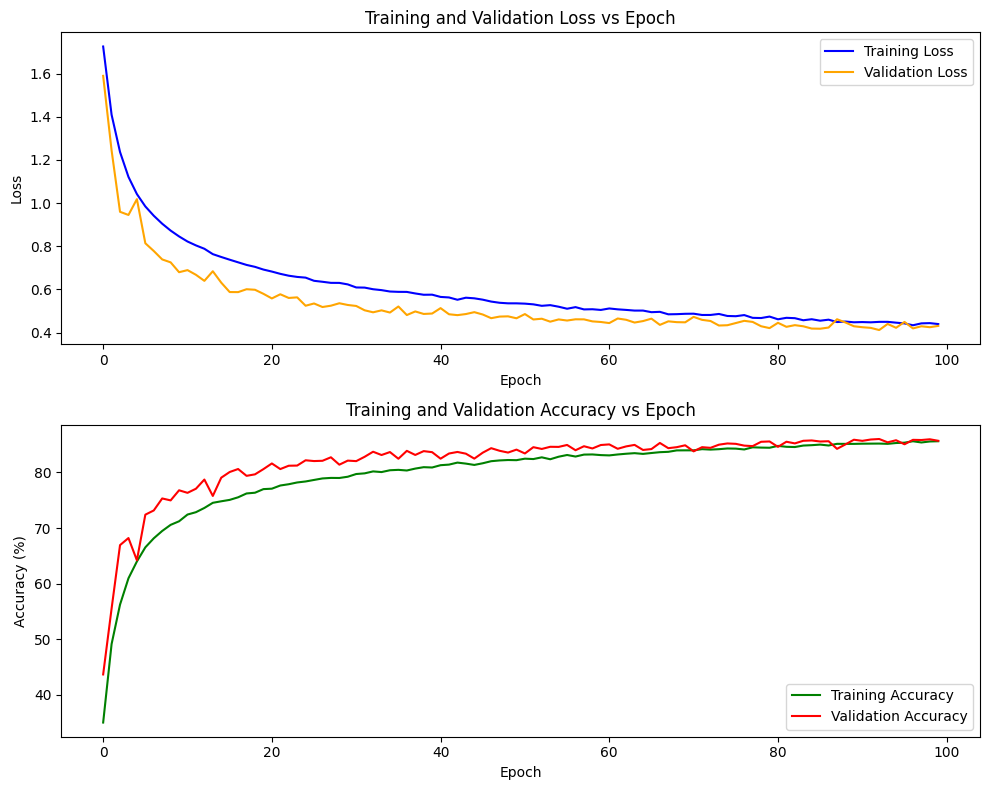

In [105]:
# Plot training and validation loss
plt.figure(figsize=(10, 8))

# Subplot 1: Training and Validation Loss
plt.subplot(2, 1, 1)
plt.plot(train_loss_list, label='Training Loss', color='blue')
plt.plot(val_loss_list, label='Validation Loss', color='orange')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss vs Epoch")
plt.legend()

# Subplot 2: Training and Validation Accuracy
plt.subplot(2, 1, 2)
plt.plot(train_acc_list, label='Training Accuracy', color='green')
plt.plot(val_acc_list, label='Validation Accuracy', color='red')
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Training and Validation Accuracy vs Epoch")
plt.legend()

plt.tight_layout()
plt.show()


In [106]:
# if model is already trained, load the model
model.load_state_dict(torch.load('lenet_model.pth'))

<All keys matched successfully>

In [107]:
# Test the model
model.eval()  # Set the model to evaluation mode
all_predictions = []
all_labels = []
with torch.no_grad():
    correct = 0
    total = 0
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(inputs)

        # Get predictions
        _, predicted = torch.max(outputs, 1)
        
        # Update lists
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        
        # Update Correct
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f"Test Accuracy: {100 * correct / total:.4f}%")


Test Accuracy: 85.7000%


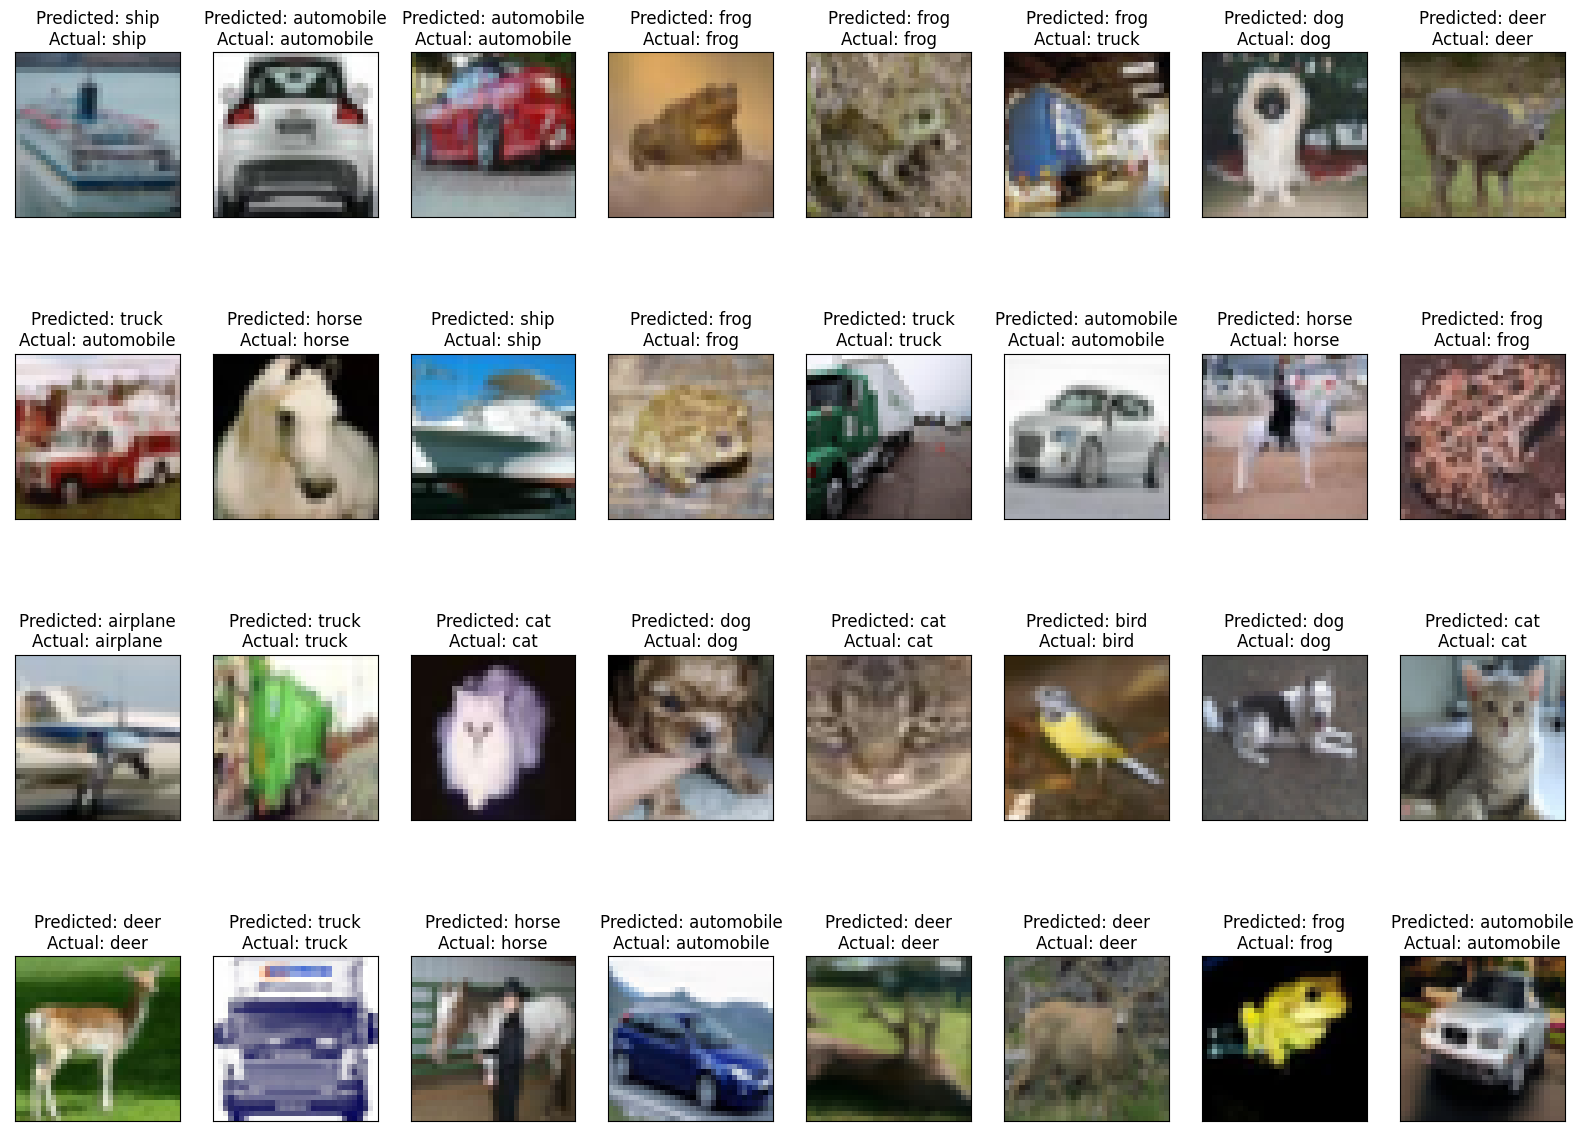

In [108]:
class_names = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
# Display the images in the test set with their predicted and actual labels

# Get a random batch from the test loader
random_batch_idx = random.randint(0, len(test_loader) - 1)
images, labels = list(test_loader)[random_batch_idx]

# Predict the labels
outputs = model(images.to(device))
_, predicted = torch.max(outputs, 1)

# Plot the images
fig = plt.figure(figsize=(20, 15))
for i in range(batch_size):
    plt.subplot(4, 8, i+1)
    plt.imshow(images[i].permute(1, 2, 0).cpu().numpy())
    plt.title(f'Predicted: {class_names[predicted[i]]}\nActual: {class_names[labels[i].item()]}')
    plt.xticks([])
    plt.yticks([])

plt.show()

AttributeError: 'Text' object has no property 'bold'

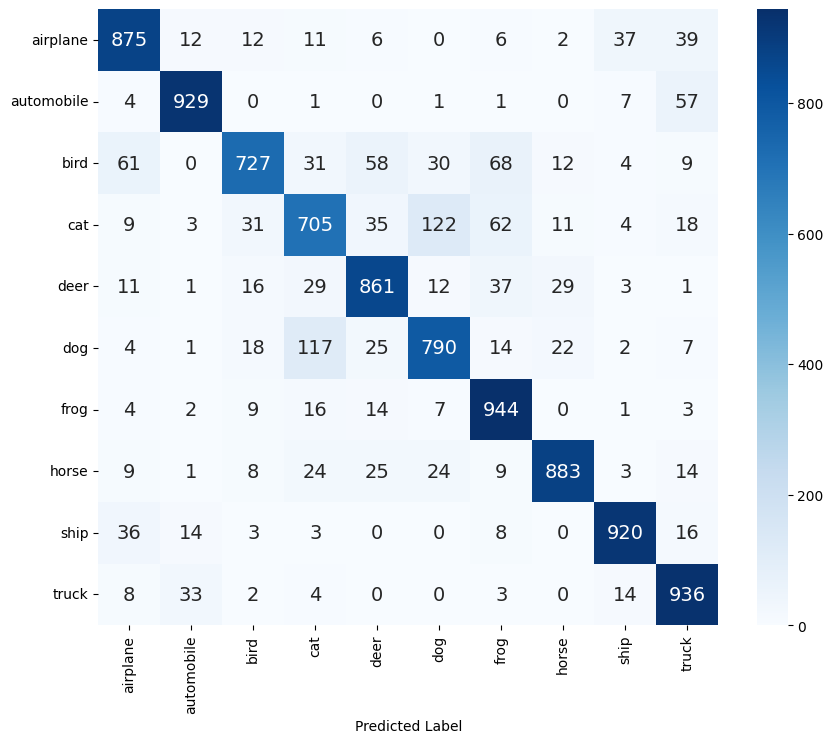

In [109]:
# Confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_predictions)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap=plt.cm.Blues, cbar=True, annot_kws={'size': 14},
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label',bold=True)
plt.ylabel('True Label',bold=True)
plt.title('Heatmap of Confusion Matrix', fontsize=16,bold=True)
plt.show()
